# Incremental Analysis of a Shallow Arch

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/claudioperez/opensees/HEAD?labpath=notebooks%2FIncrementalAnalysis%2FIncrementalAnalysis.ipynb)

![Shallow arch](./images/ClarkeHancock.png)

> Clarke, M.J. and Hancock, G.J. (1990) ‘A study of incremental‐iterative strategies for non‐linear analyses’, International Journal for Numerical Methods in Engineering, 29(7), pp. 1365–1391. Available at: https://doi.org/10.1002/nme.1620290702.


Begin by importing the `arch_model` helper function from the file [`arch.py`](./arch.py):

In [1]:
from arch import arch_model

Import some helpful third-party libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import scienceplots
    plt.style.use("steel") #(["ieee", "science", "notebook"])
except:
    pass

## The Framework

In [8]:
def analyze(model, mid, increment, steps, dx, *args):
    dof = 2

    xy = []

    status = 0

    increment(model, mid, dof, dx, *args)

    for step in range(steps):
        if status != 0:
            dx /= 2
            increment(model, mid, dof, dx, *args)

        status = model.analyze(1)

        xy.append([model.nodeDisp(mid, dof), model.getTime()])


    return np.array(xy).T


The strategies used by Clarke and Hancock are:

<dl>
<dt>Solution 1</dt><dd>
Iterative strategy: Constant load (Section 3.1)
<br/>
Load incrementation strategy: Direct incrementation of the load parameter (Section 4.1.1)
</dd>
<dt>Solution 2</dt><dd>
Iterative strategy: Constant vertical displacement under the load, $v_6$ (Section 3.2)
<br/>
Load incrementation strategy: Incrementation of the displacement component $v_6$ (Section 4.1.2)
</dd>
<dt>Solution 3</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 4</dt><dd>
Iterative strategy: Minimum unbalanced displacement norm (Section 3.5)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 5</dt><dd>
Iterative strategy: Constant weighted response (Section 3.7, equation (39))
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 6</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
<br/>
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
<dt>Solution 7</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
<br/>
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 8</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
<br/>
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
</dl>

In [9]:
def solution0(model, mid, dof, dx):
    model.integrator("LoadControl", 400.0)


def solution1(model, mid, dof, dx):
    Jd = 5
    model.integrator("LoadControl", dx, Jd, -800., 800.)


def solution2(model, mid, dof, dx):
    Jd  = 5
    model.integrator("DisplacementControl", mid, dof, dx, Jd)


def norm_control(model, mid, dof, dx):
    Jd  = 15
    model.integrator("MinUnbalDispNorm",  dx, Jd, -10, 10, "-det")


def arc_control(model, mid, dof, dx, a):
    model.integrator("ArcLength", dx, a, det=True, exp=0.5)


   FAILURE :: Iter:    25, Norm:     53104.3, Norm deltaX:     156.086
   FAILURE :: Iter:    25, Norm:     11340.8, Norm deltaX:     123.419
ArcLength::update() - imaginary roots due to multiple instability directions - initial load increment was too large
a: 6.20586 b: -2674.5 c: 319258 b24ac: -772128
   FAILURE :: Iter:    25, Norm:      3293.9, Norm deltaX:     54.5382


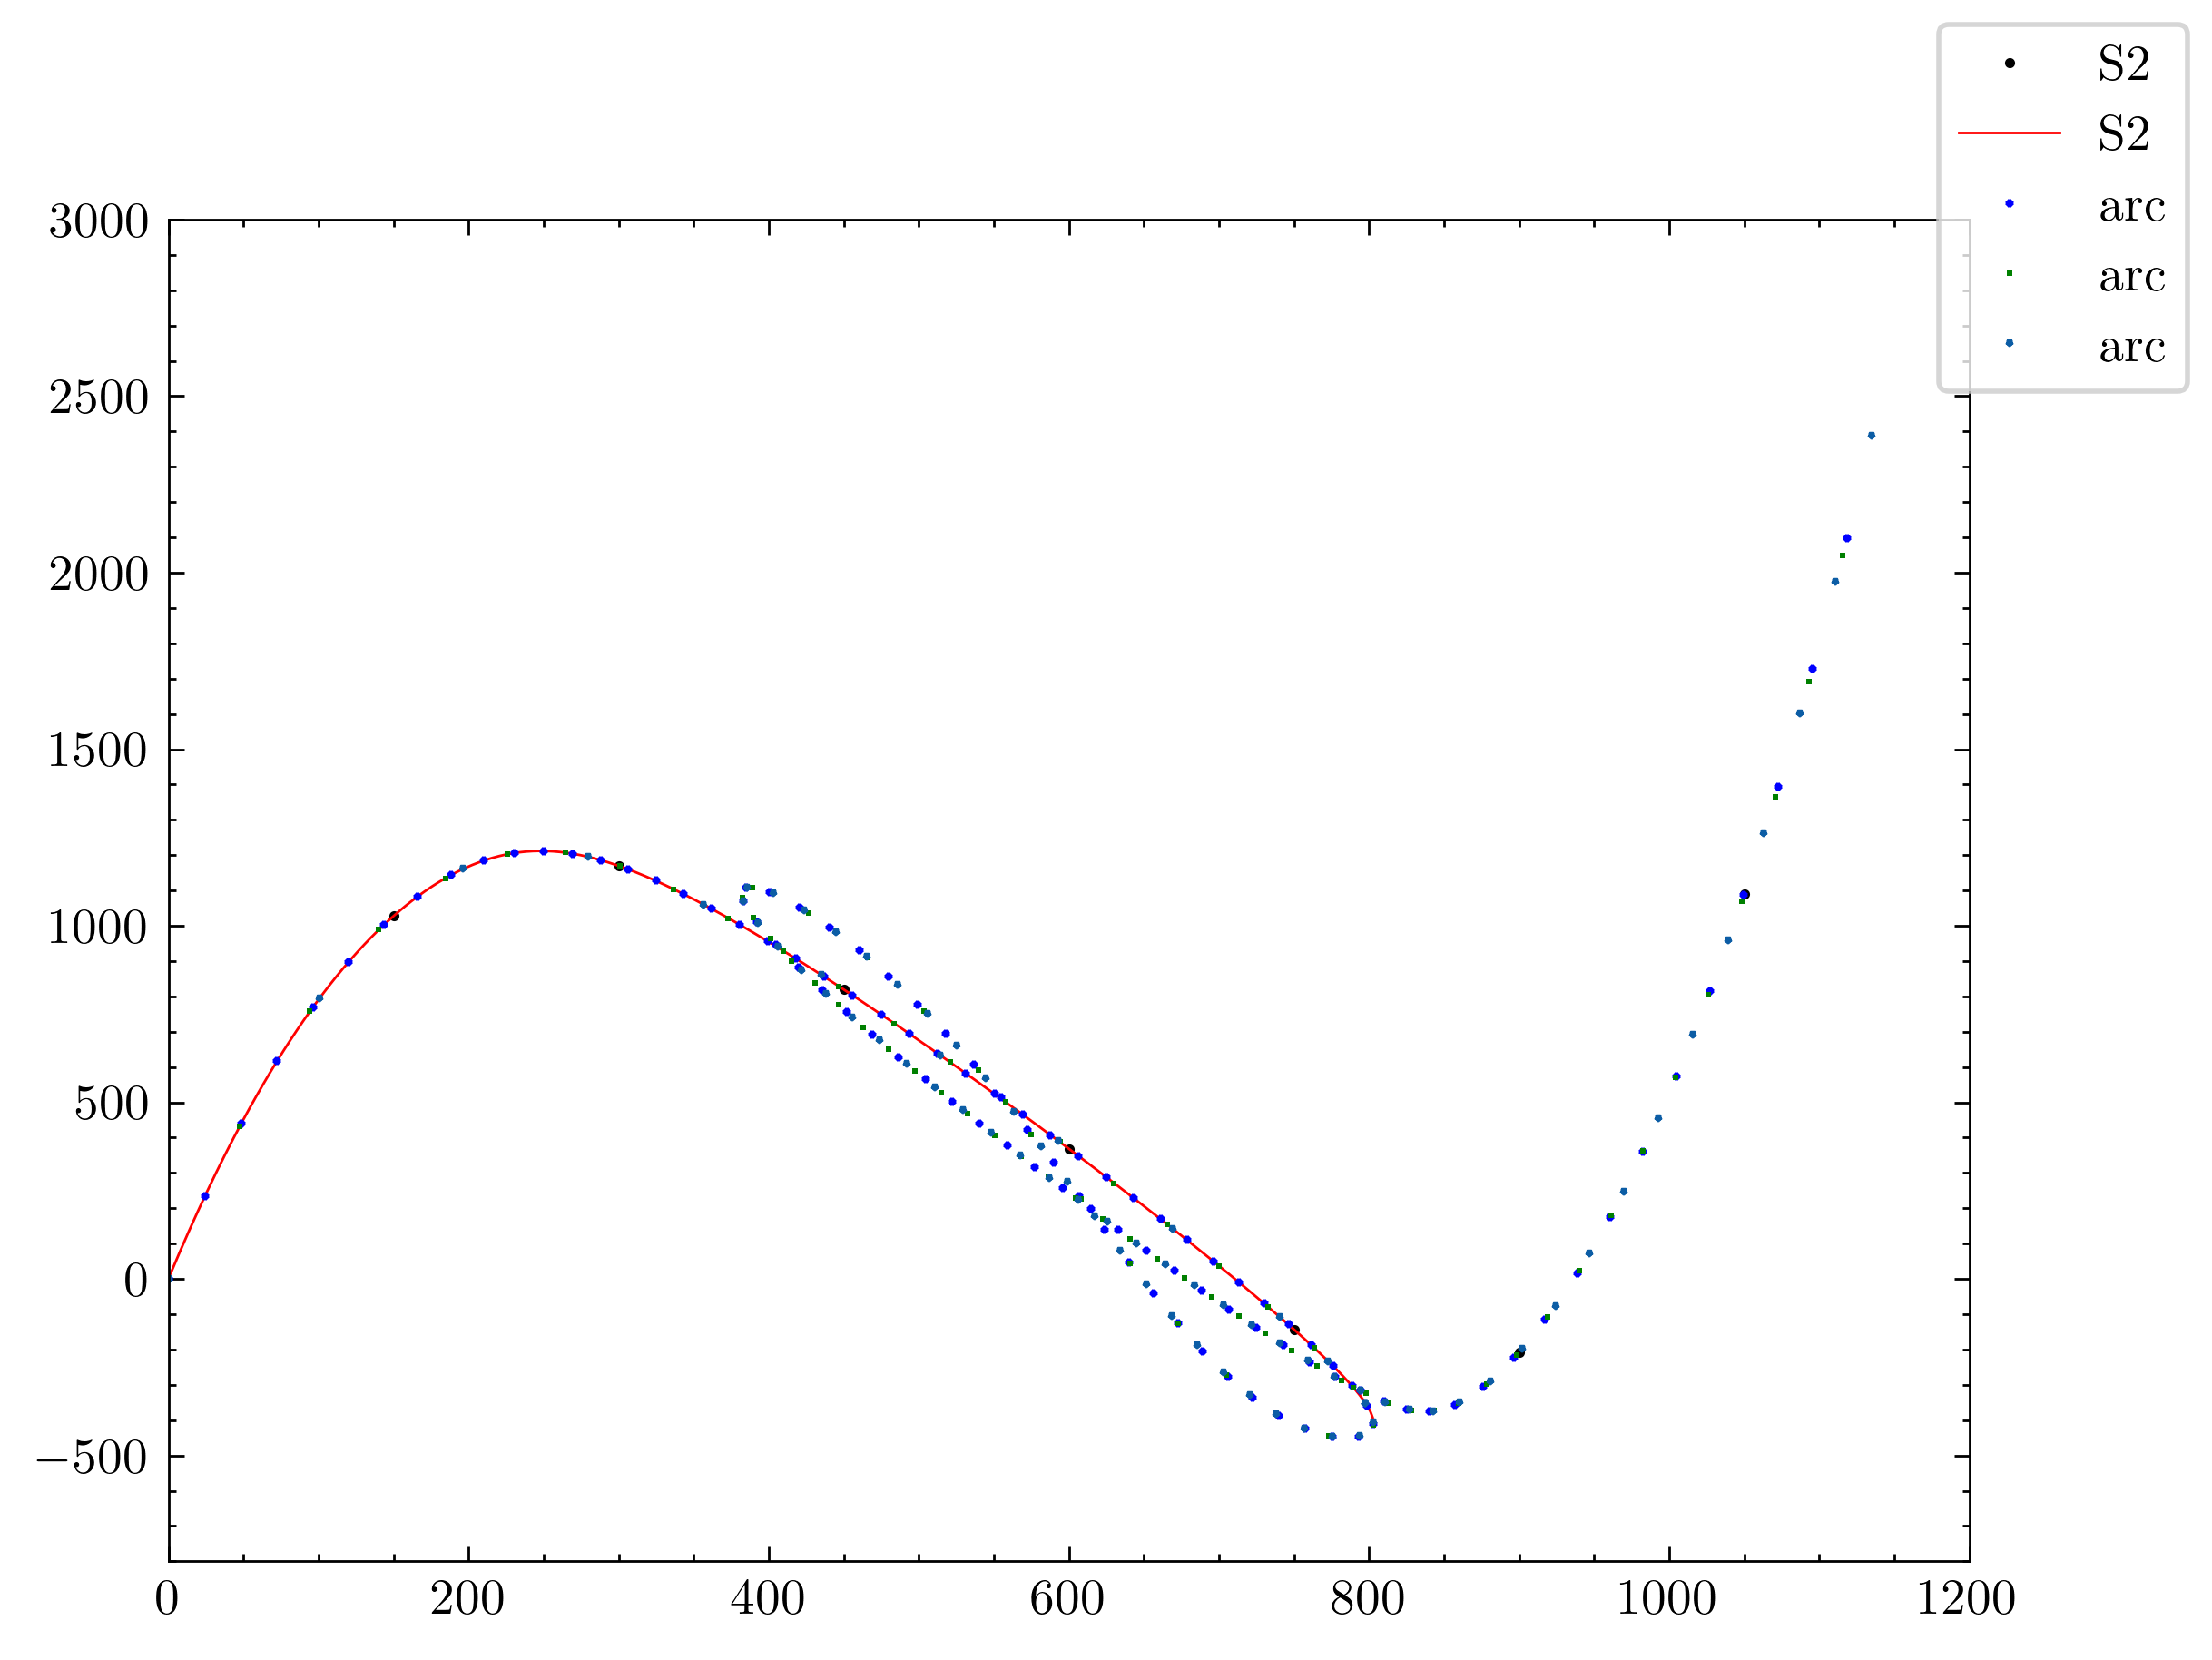

In [10]:
fig, ax = plt.subplots()

# x, y = solution0(*arch_model(), 6, 400.0)
# ax.plot(-x, y, 'x', label="S0")

# x, y = analyze(*arch_model(), solution1, 6, 400.0)
# ax.plot(-x, y, 'x', label="S1")
# print(y)

x, y = analyze(*arch_model(), solution2,    7, -150)
ax.plot(-x, y, 'o', label="S2")

x, y = analyze(*arch_model(), solution2,  536, -1.5)
ax.plot(-x, y, '-', label="S2")

# x, y = analyze(*arch_model(), arc_control, 9500, 0.5, 0)
# ax.plot(-x, y, "-", label="arc")

# Requires -det
x, y = analyze(*arch_model(), arc_control, 110,  45, 0)
ax.plot(-x, y, "x", label="arc")

x, y = analyze(*arch_model(), arc_control,  80,  88, 0)
ax.plot(-x, y, "+", label="arc")

x, y = analyze(*arch_model(), arc_control,  80, 188, 0)
ax.plot(-x, y, "*", label="arc")

# x, y = analyze(*arch_model(), arc_control, 8000, 0.8, 0)
# ax.plot(-x, y, "x", label="arc")

# x, y = analyze(*arch_model(), norm_control,  7000, 1.0)
# ax.plot(-x, y, "-", label="norm")


ax.set_xlim([0, 1200])
ax.set_ylim([-800, 3000])
fig.legend()

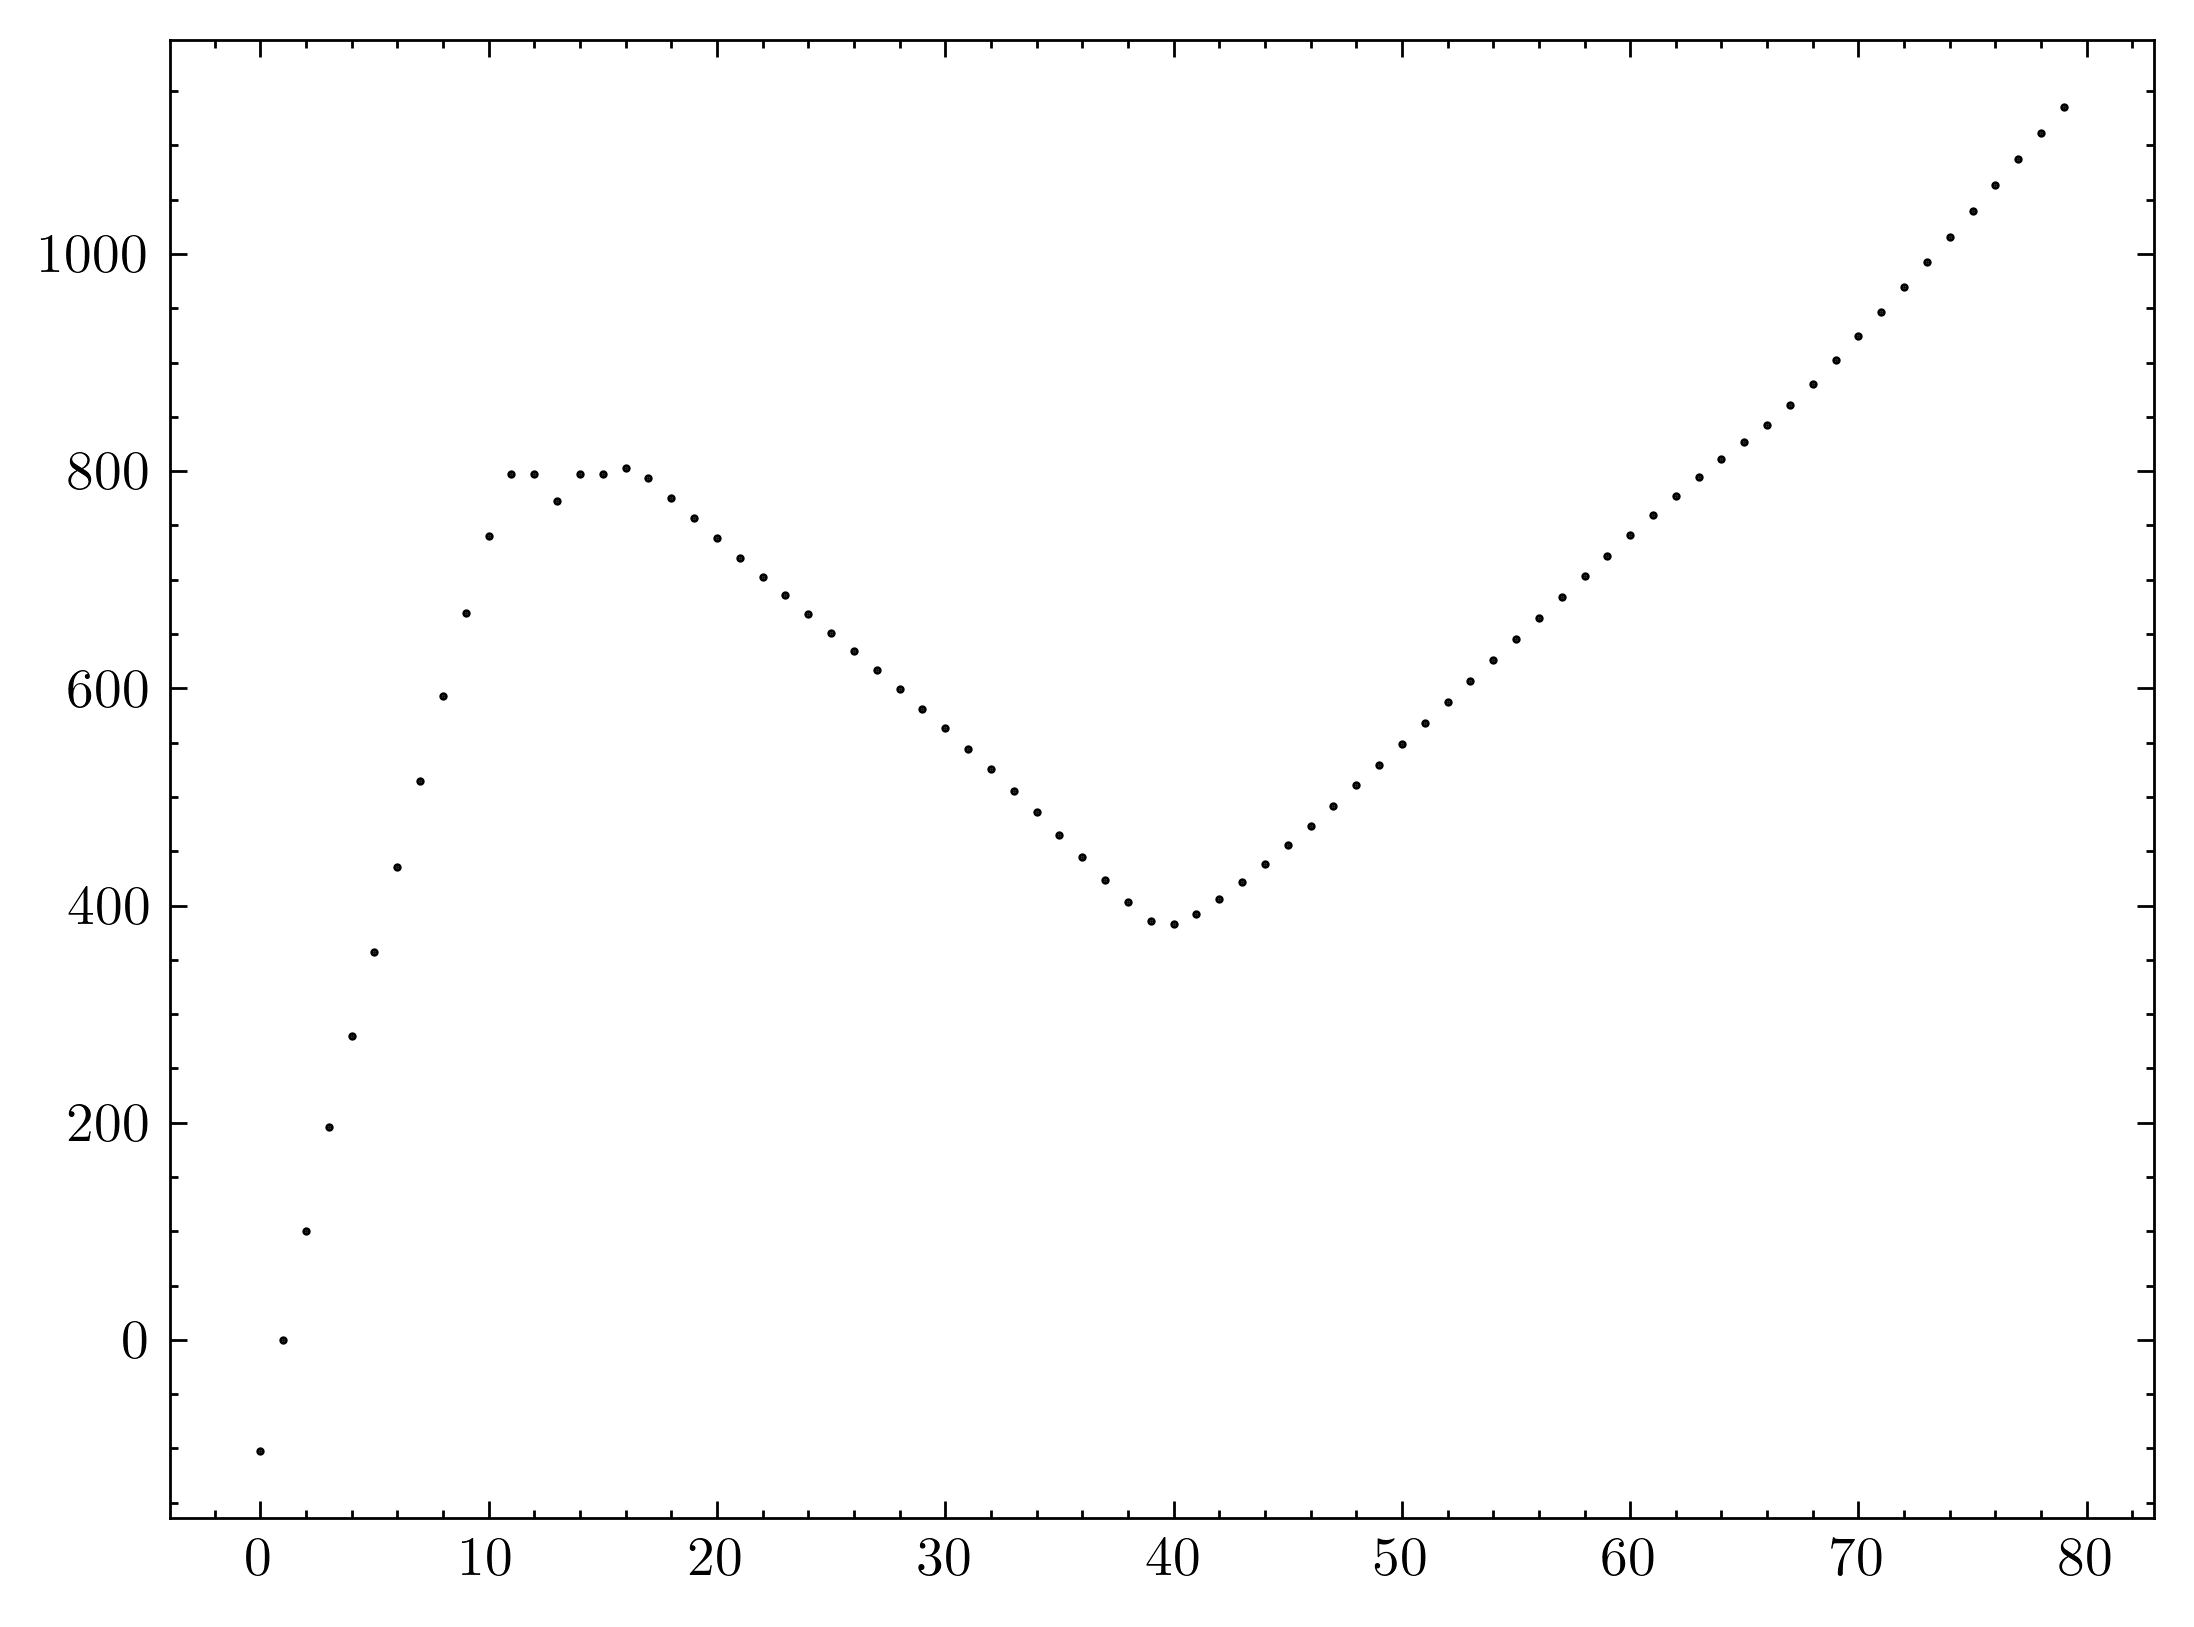

In [11]:
plt.plot(-x, '.')

In [12]:
ax.plot(-x, ".")

The following animation of the solution is created in [`Animating.ipynb`](./Animating.ipynb)

![](./arch.gif)